In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
btc = yf.download("BTC-USD", start="2020-01-01", end="2024-01-01")
eth = yf.download("ETH-USD", start="2020-01-01", end="2024-01-01")
btc.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed


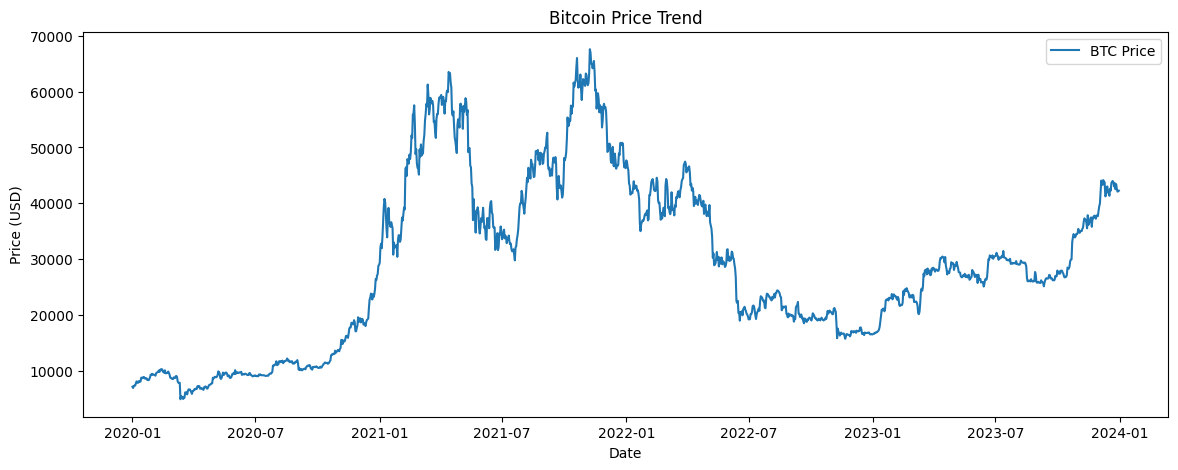

In [3]:
plt.figure(figsize=(14, 5))
plt.plot(btc['Close'], label='BTC Price')
plt.title("Bitcoin Price Trend")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

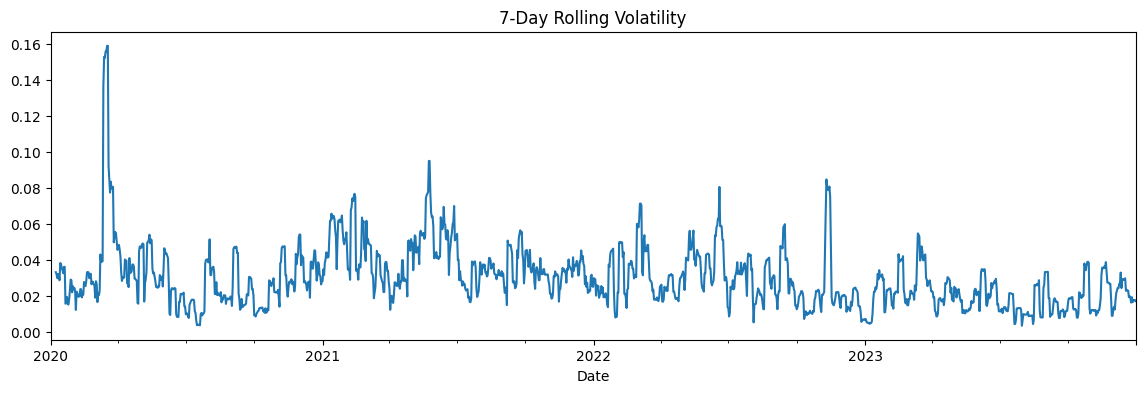

In [4]:
btc['Volatility'] = btc['Close'].pct_change().rolling(window=7).std()
btc['Volatility'].plot(title='7-Day Rolling Volatility', figsize=(14, 4))
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


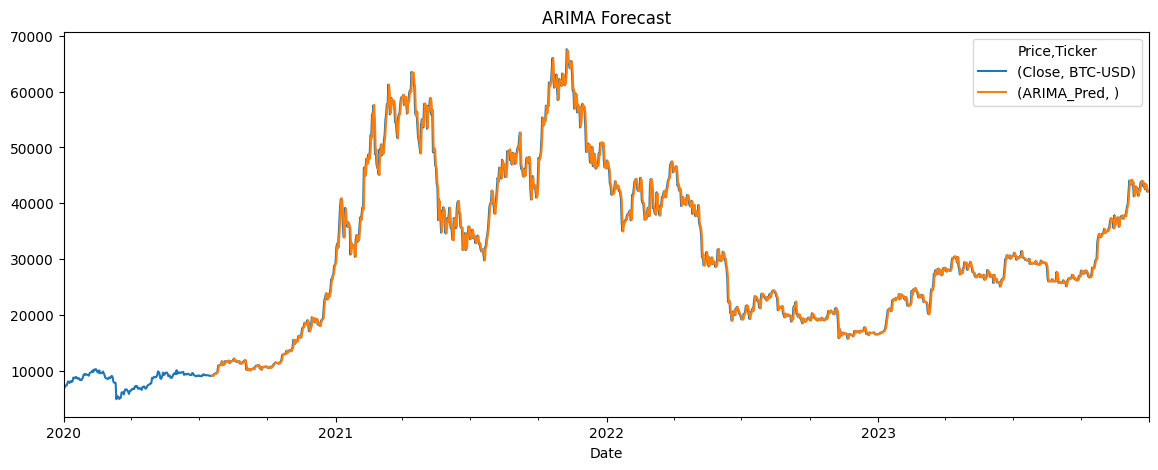

In [5]:
arima_model = ARIMA(btc['Close'], order=(5,1,0))
arima_result = arima_model.fit()
btc['ARIMA_Pred'] = arima_result.predict(start=btc.index[200], end=btc.index[-1], dynamic=False)
btc[['Close', 'ARIMA_Pred']].plot(title='ARIMA Forecast', figsize=(14,5))
plt.show()

In [6]:
df = btc[['Close']].dropna()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [7]:
train_len = int(len(df_scaled) * 0.8)
train_data = df_scaled[:train_len]
X_train, y_train = [], []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


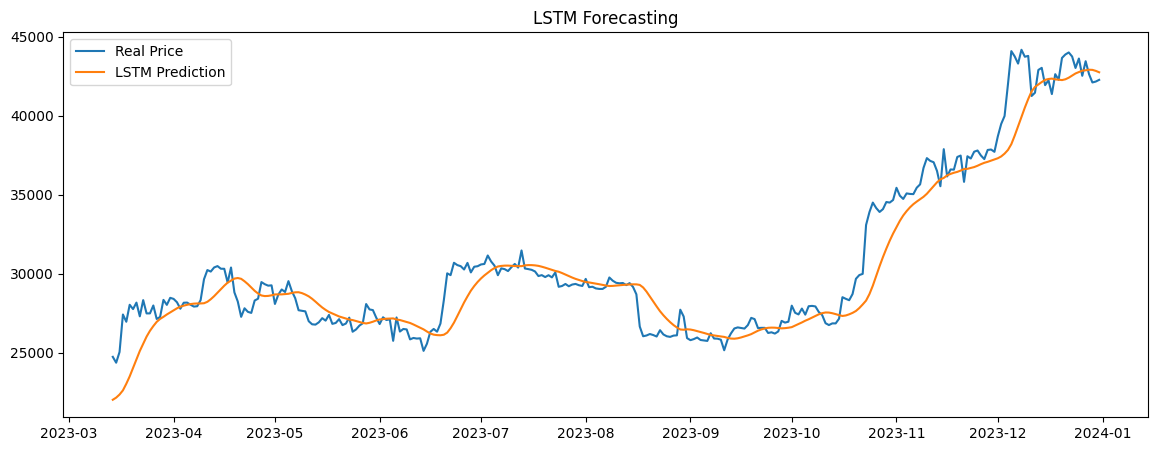

In [10]:
inputs = df_scaled[len(df_scaled)-len(df_scaled[train_len:])-60:]
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

plt.figure(figsize=(14, 5))
plt.plot(df.index[train_len:], df['Close'][train_len:], label='Real Price')
plt.plot(df.index[train_len:], predicted_price, label='LSTM Prediction')
plt.legend()
plt.title("LSTM Forecasting")
plt.show()

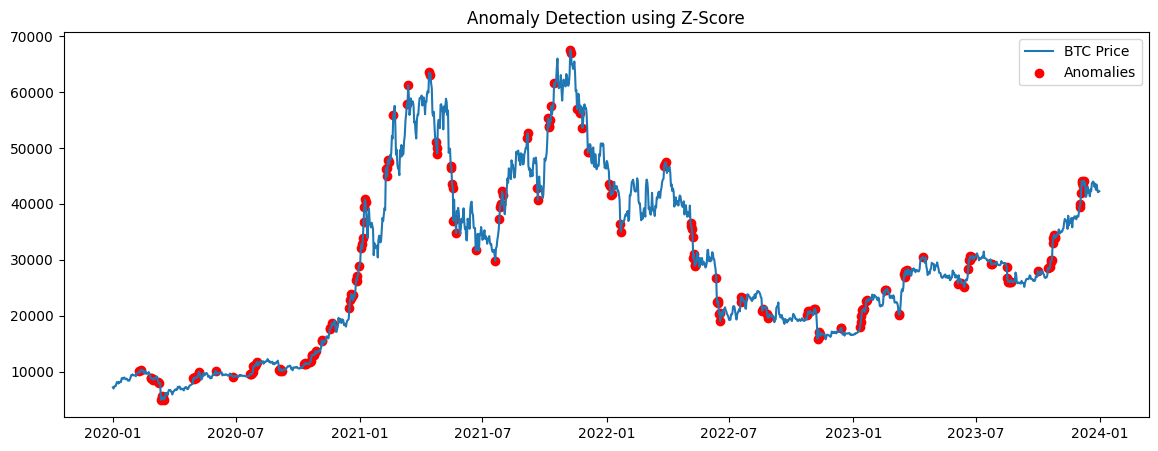

In [13]:
btc['Z_score'] = (btc['Close'] - btc['Close'].rolling(window=30).mean()) / btc['Close'].rolling(window=30).std()
anomalies = btc[np.abs(btc['Z_score']) > 2]
plt.figure(figsize=(14,5))
plt.plot(btc['Close'], label='BTC Price')
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomalies')
plt.title("Anomaly Detection using Z-Score")
plt.legend()
plt.show()